In [167]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import math

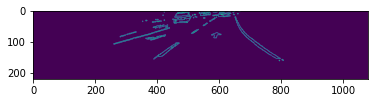

In [179]:
# 이미지
img = "./1080p/2.jpg"
A = cv2.imread(img, cv2.IMREAD_COLOR)

#roi
A_roi = A.copy()

X=200; Y=500; W=1520; H=580;
A_roi = A_roi[Y:Y+H, X:X+W]

mask1 = np.zeros(A_roi.shape[:3],dtype = np.uint8)
polygon = np.array([[350,0],[700,0],[900,200],[180,200]])
white = (255,255,255)
mask1 = cv2.fillConvexPoly(mask1,polygon,white)

a_copy = A_roi.copy()
a_result = cv2.bitwise_and(a_copy, mask1)

## 노란색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)

# hsv 색 범위 지정2
low = (20, 20, 100)
up = (31, 255, 255)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

## 흰색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)


# hsv 색 범위 지정2
low = (0, 0, 140)
up = (250, 90, 200)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

# 캐니 추출
a2_canny = cv2.Canny(a2_result, 50 , 250)

plt.imshow(a2_canny)

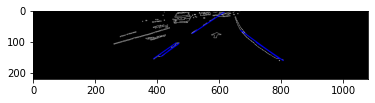

In [180]:
# 허프변환P
r = []
l = []
src = a2_result
dst = a2_canny
cdst = cv2.cvtColor(a2_canny, cv2.COLOR_GRAY2BGR)

cdstP = np.copy(cdst)

linesP = cv2.HoughLinesP(dst, 1, np.pi/180, 60, None, 5,20)
                         
#if linesP != None: 리스트에 데이터 없으면 오류나서 추가해야함 근데 데이터 있으면 오류남
for a in linesP:
    for b in a: # [] 가 두개 겹쳐있음
        if (b[2]-b[0]) != 0: # 분모가 0이면 나눌 수 없어
            radian = math.atan((b[3]-b[1])/(b[2]-b[0]))
            degree = radian * 180 / math.pi
            if degree >= 30 and degree <= 80: # 오른쪽
                r.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)
            elif degree >= -80 and degree <= -30: # 왼쪽
                l.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)
                
plt.imshow(cdstP)

In [175]:
# r과 l에서 길이 조건으로 리스트에 저장
new_r = []
new_l = []

for i in range(len(r)):
    if math.dist([r[i][0], r[i][1]], [r[i][2], r[i][3]]) > 30:
        new_r.append(r[i])
        
for i in range(len(l)):
    if math.dist([l[i][0], l[i][1]], [l[i][2], l[i][3]]) > 30:
        new_l.append(l[i])

In [181]:
new_r 

[array([669,  62, 794, 153], dtype=int32),
 array([720, 101, 806, 159], dtype=int32)]

In [182]:
new_l 

[array([388, 153, 461, 102], dtype=int32),
 array([436, 128, 470, 104], dtype=int32),
 array([412, 146, 468, 106], dtype=int32),
 array([513,  72, 616,   3], dtype=int32)]

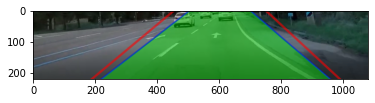

In [186]:
# roi이미지에서 선 그리기
a_copy = A_roi.copy()

# r 에서 x0 최소값이 있는 인덱스 i 찾기
least = []
for x in new_r:
    least.append(x[0])


least2 = []
for x in new_l:
    least2.append(x[2])

    
if not least:
    least_a = least_b
    least.append(least_a)
    i = least2.index(least_a)
    most_a = most_b
    least.append(most_a)
    i2 = least2.index(max_a)
    least_b = min(least2)
    i3 = least2.index(least_b)
    most_b = max(least2)
    i4 = least2.index(most_b)
    a_copy2 = a_copy.copy()
    

    ## l1
    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
    n3 = l[i3][1] - (m3 * l[i3][0])

    ## l2
    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
    n4 = l[i4][1] - (m4 * l[i4][0])

    ## r1
    m = -m3
    n = l[i][1] - (m * (550-(l[i][0]-550)))

    ## r2
    m2 = -m4
    n2 = l[i2][1] - (m2 * (550-(l[i2][0]-500)))
    
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+100, 300),(int((580-n)/m), 580), (0, 0, 255), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-100, 300),(int((580-n4)/m4), 580), (0, 0, 255), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+150, 300),(int((580-n)/m), 580), (255, 0, 0), 5, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-150, 300),(int((580-n4)/m4), 580), (255, 0, 0), 5, cv2.LINE_AA)
    
    
elif not least2:
    least_a = min(least)
    i = least.index(least_a)
    most_a = max(least)
    i2 = least.index(most_a)
    least_b = least_a
    i3 = least.index(least_b)
    most_b = most_a
    i4 = least.index(most_b)    
    a_copy2 = a_copy.copy()
    
    ## r
    m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
    n = r[i][1] - (m * r[i][0])

    ## r2
    m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
    n2 = r[i2][1] - (m2 * r[i2][0])

    ## l1
    m3 = -m
    n3 = r[i][1] - (m3 * (550-(r[i][0]-550)))

    ## l2
    m4 = -m2
    n4 = r[i2][1] - (m4 * (550-(r[i2][0]-550)))

    
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+100, 300),(int((580-n)/m), 580), (0, 0, 255), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-100, 300),(int((580-n4)/m4), 580), (0, 0, 255), 4, cv2.LINE_AA)
    
    
else:
    least_a = min(least)
    i = least.index(least_a)
    most_a = max(least)
    i2 = least.index(most_a)
    least_b = min(least2)
    i3 = least2.index(least_b)
    most_b = max(least2)
    i4 = least2.index(most_b)
    a_copy2 = a_copy.copy()
    
    ## r1
    m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
    n = r[i][1] - (m * r[i][0])

    ## r2
    m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
    n2 = r[i2][1] - (m2 * r[i2][0])

    ## l1
    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
    n3 = l[i3][1] - (m3 * l[i3][0])

    ## l2
    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
    n4 = l[i4][1] - (m4 * l[i4][0])

    
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+100, 0),(int((580-n)/m), 580), (0, 0, 255), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-100, 0),(int((580-n4)/m4), 580), (0, 0, 255), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+150, 0),(int((580-n)/m), 580), (255, 0, 0), 5, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-150, 0),(int((580-n4)/m4), 580), (255, 0, 0), 5, cv2.LINE_AA)
    
    
a_copy3 = A_roi.copy()

pts = np.array([[int(((-n4/m4)+(-n/m))/2)+100, 0], [int(((-n4/m4)+(-n/m))/2)-100, 0],
                [int((580-n4)/m4), 580],[int((580-n)/m), 580]], np.int32)
area = cv2.fillPoly(a_copy3, [pts], (0, 255, 0))
a_copy4 = cv2.addWeighted(a_copy3, 0.4, a_copy2, 0.6, 0)

plt.imshow(a_copy4)

In [184]:
cv2.imshow("a_copy", a_copy4)

cv2.waitKey()
cv2.destroyAllWindows()